In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths

import os

import torch
from opts import opts
from models.model import create_model, load_model, save_model
from models.data_parallel import DataParallel
from logger import Logger
from datasets.dataset_factory import get_dataset
from trains.train_factory import train_factory


import torch.utils.data as data
import numpy as np
import torch
import json
import cv2
import os
from utils.image import flip, color_aug
from utils.image import get_affine_transform, affine_transform
from utils.image import gaussian_radius, draw_umich_gaussian, draw_msra_gaussian
from utils.image import draw_dense_reg
import math

Using tensorboardX


In [2]:
dataset = 'coco'
task = 'gridneighbordet'
Dataset = get_dataset(dataset, task)

opt = opts().parse(args=[])
#Dataset = get_dataset(opt.dataset)
opt = opts().update_dataset_info_and_set_heads(opt, Dataset)
print(opt)


Fix size testing.
training chunk_sizes: [1]
The output will be saved to  /data/mry/code/CenterNet/src/lib/../../exp/gridneighbordet/gridneighbordet-debug-loss
heads {'hm': 80, 'wh': 2, 'reg': 2}
Namespace(K=100, aggr_weight=0.0, agnostic_ex=False, arch='hourglass', aug_ddd=0.5, aug_rot=0, batch_size=1, cat_spec_wh=False, center_thresh=0.1, chunk_sizes=[1], data_dir='/data/mry/DataSet/', dataset='coco', debug=2, debug_dir='/data/mry/code/CenterNet/src/lib/../../exp/gridneighbordet/gridneighbordet-debug-loss/debug', debugger_theme='white', demo='/data/mry/DataSet/COCO/val2014', dense_hp=False, dense_wh=False, dep_weight=1, det_output_path='', dim_weight=1, down_ratio=4, eval_oracle_dep=False, eval_oracle_hm=False, eval_oracle_hmhp=False, eval_oracle_hp_offset=False, eval_oracle_kps=False, eval_oracle_offset=False, eval_oracle_wh=False, exp_dir='/data/mry/code/CenterNet/src/lib/../../exp/gridneighbordet', exp_id='gridneighbordet-debug-loss', fix_res=True, flip=0, flip_test=False, gpus=[0]

In [3]:
class generate_spec_points():
    
    def __init__(self, points_list):
        super(generate_spec_points, self).__init__()
        self.points_list = [int(i) for i in points_list]
        self.points_num = len(self.points_list)

In [4]:
test = Dataset(opt, 'train')

==> initializing coco 2014 train data.
loading annotations into memory...
Done (t=11.77s)
creating index...
index created!
Loaded train 82783 samples


In [17]:
sample = test[6]
print(type(sample['input']))


<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


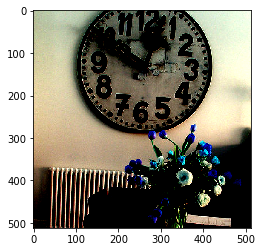

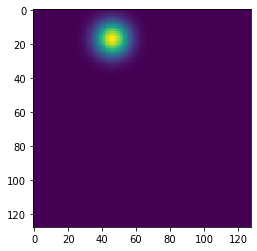

In [18]:
import matplotlib.pyplot as plt
plt.imshow(sample['input'].transpose((1,2,0)))
plt.show()
plt.imshow(sample['hm'][74])
plt.show()

In [19]:
print(sample.keys())
print(sample['meta'])



dict_keys(['input', 'hm', 'reg_mask', 'ind', 'wh', 'reg', 'meta'])
{'c': array([238., 246.], dtype=float32), 's': 384.0, 'gt_det': array([[ 26.516668, 104.486664, 127.      , 127.      ,   1.      ,
         60.      ],
       [ 32.350002, 104.84    ,  44.66    , 123.20334 ,   1.      ,
         56.      ],
       [110.98    , 109.37333 , 124.39333 , 126.840004,   1.      ,
         56.      ],
       [121.670006, 119.98334 , 126.99999 , 127.      ,   1.      ,
         56.      ],
       [ 27.333334,   0.      , 105.47667 ,  71.64667 ,   1.      ,
         74.      ],
       [ 76.23334 , 115.753334,  91.06668 , 127.00001 ,   1.      ,
         75.      ],
       [ 89.496666, 119.84    , 116.35668 , 127.      ,   1.      ,
         73.      ],
       [ 29.586664, 116.24    ,  41.32666 , 127.00001 ,   1.      ,
         56.      ]], dtype=float32), 'img_id': 122688}


In [20]:
print(sample['wh'].shape)

(32, 2)


In [21]:
print(sample['wh'])

[[ 0.         0.       ]
 [25.120832   5.628334 ]
 [ 3.0774994  4.5908356]
 [ 3.3533325  4.3666687]
 [ 1.3324966  1.7541656]
 [ 0.         0.       ]
 [19.535833  17.911667 ]
 [ 0.         0.       ]
 [ 3.7083359  2.8116684]
 [ 6.715004   1.7900009]
 [ 0.         0.       ]
 [ 2.9349995  2.6900024]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]]


In [22]:
print(sample['ind'])

[[    0]
 [14131]
 [13987]
 [14578]
 [15611]
 [    0]
 [ 2222]
 [    0]
 [15183]
 [15584]
 [    0]
 [15136]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]]


In [54]:
gridneighbortest = Dataset(opt, 'val')

==> initializing coco 2014 val data.
loading annotations into memory...
Done (t=5.04s)
creating index...
index created!
Loaded val 40504 samples


In [8]:
gridsample = gridneighbortest[0]

In [12]:
print(gridsample.keys())
gridsample['wh'][:1,:]

dict_keys(['input', 'hm', 'reg_mask', 'ind', 'wh', 'reg', 'meta'])


array([[ 5.6224976, 10.678497 , 11.244995 , 10.678497 , 16.8675   ,
        10.678497 , 11.244995 , 32.0355   , 16.8675   , 32.0355   ]],
      dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


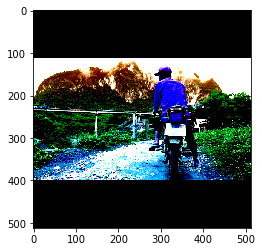

In [15]:
import matplotlib.pyplot as plt
plt.imshow(gridsample['input'].transpose((1,2,0)))
plt.show()


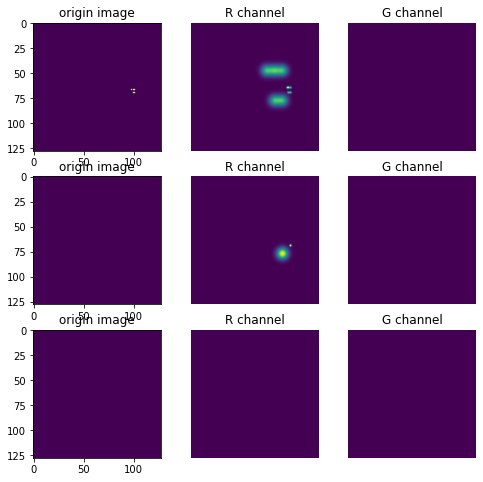

In [13]:
import matplotlib.pyplot as plt
plt.figure(num='astronaut',figsize=(8,8))  #创建一个名为astronaut的窗口,并设置大小 

plt.subplot(3,3,1)     #将窗口分为两行两列四个子图，则可显示四幅图片
plt.title('origin image')   #第一幅图片标题
plt.imshow(gridsample['hm'][5] + gridsample['hm'][6]+ + gridsample['hm'][7]
          +gridsample['hm'][8] + gridsample['hm'][9])      #绘制第一幅图片

plt.subplot(3,3,2)     #第二个子图
plt.title('R channel')   #第二幅图片标题
plt.imshow(gridsample['hm'][0] + gridsample['hm'][1] +gridsample['hm'][2]
          +gridsample['hm'][3] + gridsample['hm'][4])      #绘制第二幅图片,且为灰度图
plt.axis('off')     #不显示坐标尺寸

plt.subplot(3,3,3)     #第三个子图
plt.title('G channel')   #第三幅图片标题
plt.imshow(gridsample['hm'][29])      #绘制第三幅图片,且为灰度图
plt.axis('off')     #不显示坐标尺寸

plt.subplot(3,3,4)     #将窗口分为两行两列四个子图，则可显示四幅图片
plt.title('origin image')   #第一幅图片标题
plt.imshow(gridsample['hm'][30])      #绘制第一幅图片

plt.subplot(3,3,5)     #第二个子图
plt.title('R channel')   #第二幅图片标题
plt.imshow(gridsample['hm'][31] + gridsample['hm'][4])      #绘制第二幅图片,且为灰度图
plt.axis('off')     #不显示坐标尺寸

plt.subplot(3,3,6)     #第三个子图
plt.title('G channel')   #第三幅图片标题
plt.imshow(gridsample['hm'][32])      #绘制第三幅图片,且为灰度图
plt.axis('off')     #不显示坐标尺寸

plt.subplot(3,3,7)     #将窗口分为两行两列四个子图，则可显示四幅图片
plt.title('origin image')   #第一幅图片标题
plt.imshow(gridsample['hm'][33])      #绘制第一幅图片

plt.subplot(3,3,8)     #第二个子图
plt.title('R channel')   #第二幅图片标题
plt.imshow(gridsample['hm'][34])      #绘制第二幅图片,且为灰度图
plt.axis('off')     #不显示坐标尺寸

plt.subplot(3,3,9)     #第三个子图
plt.title('G channel')   #第三幅图片标题
plt.imshow(gridsample['hm'][35])      #绘制第三幅图片,且为灰度图
plt.axis('off')     #不显示坐标尺寸


plt.show()   #显示窗口

In [58]:
print(gridsample['wh'].shape)
gridsample['wh'][0]

(128, 2)


array([22.489998, 42.713997], dtype=float32)

In [12]:
class GridNeighborDetDataset(data.Dataset):
  def _coco_box_to_bbox(self, box):
    bbox = np.array([box[0], box[1], box[0] + box[2], box[1] + box[3]],
                    dtype=np.float32)
    return bbox

  def _get_border(self, border, size):
    i = 1
    while size - border // i <= border // i:
        i *= 2
    return border // i

  def __getitem__(self, index):
    main_points = generate_spec_points(self.opt.point_flags)
    main_points_list = main_points.points_list
    main_points_list.sort()
    main_points_num = main_points.points_num
    
    img_id = self.images[index]
    file_name = self.coco.loadImgs(ids=[img_id])[0]['file_name']
    img_path = os.path.join(self.img_dir, file_name)
    ann_ids = self.coco.getAnnIds(imgIds=[img_id])
    anns = self.coco.loadAnns(ids=ann_ids)
    num_objs = min(len(anns), self.max_objs)

    img = cv2.imread(img_path)

    height, width = img.shape[0], img.shape[1]
    c = np.array([img.shape[1] / 2., img.shape[0] / 2.], dtype=np.float32)
    if self.opt.keep_res:
      input_h = (height | self.opt.pad) + 1
      input_w = (width | self.opt.pad) + 1
      s = np.array([input_w, input_h], dtype=np.float32)
    else:
      s = max(img.shape[0], img.shape[1]) * 1.0
      input_h, input_w = self.opt.input_h, self.opt.input_w
    
    flipped = False
    if self.split == 'train':
      if not self.opt.not_rand_crop:
        s = s * np.random.choice(np.arange(0.6, 1.4, 0.1))
        w_border = self._get_border(128, img.shape[1])
        h_border = self._get_border(128, img.shape[0])
        c[0] = np.random.randint(low=w_border, high=img.shape[1] - w_border)
        c[1] = np.random.randint(low=h_border, high=img.shape[0] - h_border)
      else:
        sf = self.opt.scale
        cf = self.opt.shift
        c[0] += s * np.clip(np.random.randn()*cf, -2*cf, 2*cf)
        c[1] += s * np.clip(np.random.randn()*cf, -2*cf, 2*cf)
        s = s * np.clip(np.random.randn()*sf + 1, 1 - sf, 1 + sf)
      
      if np.random.random() < self.opt.flip:
        flipped = True
        img = img[:, ::-1, :]
        c[0] =  width - c[0] - 1
        

    trans_input = get_affine_transform(
      c, s, 0, [input_w, input_h])
    inp = cv2.warpAffine(img, trans_input, 
                         (input_w, input_h),
                         flags=cv2.INTER_LINEAR)
    inp = (inp.astype(np.float32) / 255.)
    if self.split == 'train' and not self.opt.no_color_aug:
      color_aug(self._data_rng, inp, self._eig_val, self._eig_vec)
    inp = (inp - self.mean) / self.std
    inp = inp.transpose(2, 0, 1)

    output_h = input_h // self.opt.down_ratio
    output_w = input_w // self.opt.down_ratio
    num_classes = self.num_classes
    trans_output = get_affine_transform(c, s, 0, [output_w, output_h])

    hm = np.zeros((num_classes, output_h, output_w), dtype=np.float32)
    hm = np.zeros((main_points_num*num_classes, output_h, output_w), dtype=np.float32)
    
    wh = np.zeros((self.max_objs, 2), dtype=np.float32)
    wh = np.zeros((self.max_objs, 2), dtype=np.float32)
    
    dense_wh = np.zeros((2, output_h, output_w), dtype=np.float32)
    dense_wh = np.zeros((main_points_num*2, output_h, output_w), dtype=np.float32)
    
    reg = np.zeros((self.max_objs, 2), dtype=np.float32)
    reg = np.zeros((self.max_objs, 2*main_points_num), dtype=np.float32)
    
    ind = np.zeros((self.max_objs), dtype=np.int64)
    ind = np.zeros((self.max_objs, main_points_num), dtype=np.int64)
    
    reg_mask = np.zeros((self.max_objs), dtype=np.uint8)
    reg_mask = np.zeros((self.max_objs, main_points_num), dtype=np.uint8)
    
    cat_spec_wh = np.zeros((self.max_objs, num_classes * 2), dtype=np.float32)
    cat_spec_mask = np.zeros((self.max_objs, num_classes * 2), dtype=np.uint8)
    
    draw_gaussian = draw_msra_gaussian if self.opt.mse_loss else \
                    draw_umich_gaussian

    gt_det = []
    for k in range(num_objs):
      ann = anns[k]
      bbox = self._coco_box_to_bbox(ann['bbox'])
      cls_id = int(self.cat_ids[ann['category_id']])
      if flipped:
        bbox[[0, 2]] = width - bbox[[2, 0]] - 1
      bbox[:2] = affine_transform(bbox[:2], trans_output)
      bbox[2:] = affine_transform(bbox[2:], trans_output)
      bbox[[0, 2]] = np.clip(bbox[[0, 2]], 0, output_w - 1)
      bbox[[1, 3]] = np.clip(bbox[[1, 3]], 0, output_h - 1)
      h, w = bbox[3] - bbox[1], bbox[2] - bbox[0]
      if h > 0 and w > 0:
        radius = gaussian_radius((math.ceil(h), math.ceil(w)))
        radius = max(0, int(radius))
        radius = self.opt.hm_gauss if self.opt.mse_loss else radius
        wh[k] = 1. * w, 1. * h
        
        for idx, main_points in enumerate(main_points_list):
            row = main_points//3
            col = main_points%3
            ct = np.array([(bbox[0] + bbox[2])*(col+1) / 4, (bbox[1] + bbox[3])*(row+1)/4], dtype=np.float32)
            ct_int = ct.astype(np.int32)
            draw_gaussian(hm[cls_id*main_points_num+idx], ct_int, radius)
            
            ind[k][idx] = ct_int[1] * output_w + ct_int[0]
            reg[k][2*idx:2*idx+2] = ct - ct_int
            wh[k][[2*idx:2*idx+2]] = np.array([ct[0]-bbox[0], ct[1]-bbox[1]])
            reg_mask[k][idx] = 1
            cat_spec_wh[k, cls_id * 2: cls_id * 2 + 2] = wh[k]
            cat_spec_mask[k, cls_id * 2: cls_id * 2 + 2] = 1
            
            gt_det.append([ct[0] - w / 2, ct[1] - h / 2, 
               ct[0] + w / 2, ct[1] + h / 2, 1, cls_id])
        '''
            ct_int = ct.astype(np.int32)
            draw_gaussian(hm[cls_id], ct_int, radius)

            ind[k] = ct_int[1] * output_w + ct_int[0]
            reg[k] = ct - ct_int
            reg_mask[k] = 1
            cat_spec_wh[k, cls_id * 2: cls_id * 2 + 2] = wh[k]
            cat_spec_mask[k, cls_id * 2: cls_id * 2 + 2] = 1
            if self.opt.dense_wh:
              draw_dense_reg(dense_wh, hm.max(axis=0), ct_int, wh[k], radius)
            gt_det.append([ct[0] - w / 2, ct[1] - h / 2, 
                           ct[0] + w / 2, ct[1] + h / 2, 1, cls_id])
        '''
    
    ret = {'input': inp, 'hm': hm, 'reg_mask': reg_mask, 'ind': ind, 'wh': wh}
    if self.opt.dense_wh:
      hm_a = hm.max(axis=0, keepdims=True)
      dense_wh_mask = np.concatenate([hm_a, hm_a], axis=0)
      ret.update({'dense_wh': dense_wh, 'dense_wh_mask': dense_wh_mask})
      del ret['wh']
    elif self.opt.cat_spec_wh:
      ret.update({'cat_spec_wh': cat_spec_wh, 'cat_spec_mask': cat_spec_mask})
      del ret['wh']
    if self.opt.reg_offset:
      ret.update({'reg': reg})
    if self.opt.debug > 0 or not self.split == 'train':
      gt_det = np.array(gt_det, dtype=np.float32) if len(gt_det) > 0 else \
               np.zeros((1, 6), dtype=np.float32)
      meta = {'c': c, 's': s, 'gt_det': gt_det, 'img_id': img_id}
      ret['meta'] = meta
    return ret

In [6]:
pwd()

'/data/mry/code/CenterNet/src'

In [10]:
train_loader = torch.utils.data.DataLoader(
  Dataset(opt, 'train'),
  batch_size=opt.batch_size,
  shuffle=True,
  num_workers=opt.num_workers,
  pin_memory=True,
  drop_last=True
)

==> initializing coco 2014 train data.
loading annotations into memory...
Done (t=15.66s)
creating index...
index created!
Loaded train 82783 samples


In [11]:
test = Dataset(opt, 'train')

==> initializing coco 2014 train data.
loading annotations into memory...
Done (t=11.16s)
creating index...
index created!
Loaded train 82783 samples


In [12]:
sample = test[1]

ValueError: negative dimensions are not allowed

In [40]:

print(sample.keys())
sample['wh'].shape

dict_keys(['input', 'hm', 'reg_mask', 'ind', 'wh', 'reg'])


(128, 2)

In [13]:
opt

Namespace(K=4, aggr_weight=0.0, agnostic_ex=False, arch='hourglass', aug_ddd=0.5, aug_rot=0, batch_size=32, cat_spec_wh=False, center_thresh=0.1, chunk_sizes=[16, 16], data_dir='/data/mry/DataSet/', dataset='coco', debug=0, debug_dir='/data/mry/code/CenterNet/src/lib/../../exp/ctdet/coco/debug', debugger_theme='white', demo='', dense_hp=False, dense_wh=False, dep_weight=1, det_output_path='', dim_weight=1, down_ratio=4, eval_oracle_dep=False, eval_oracle_hm=False, eval_oracle_hmhp=False, eval_oracle_hp_offset=False, eval_oracle_kps=False, eval_oracle_offset=False, eval_oracle_wh=False, exp_dir='/data/mry/code/CenterNet/src/lib/../../exp/ctdet', exp_id='coco', fix_res=True, flip=0, flip_test=False, gpus=[0, 1], gpus_str='1,2', head_conv=64, hide_data_time=False, hm_hp=True, hm_hp_weight=1, hm_weight=1, hp_weight=1, input_h=-1, input_res=-1, input_w=-1, keep_inp_res_prob=0, keep_res=False, kitti_split='3dop', load_model='', logger_iteration=1, lr=0.000125, lr_step=[90, 120], master_batch

1.4.0


True

'/data/mry/code/CenterNet/src'

In [28]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths

import os

import torch
import torch.utils.data
from opts import opts
from models.model import create_model, load_model, save_model
from models.data_parallel import DataParallel
from logger import Logger
from datasets.dataset_factory import get_dataset
from trains.train_factory import train_factory


def main(opt):
  torch.manual_seed(opt.seed)
  torch.backends.cudnn.benchmark = not opt.not_cuda_benchmark and not opt.test
  Dataset = get_dataset(opt.dataset, opt.task)
  #Dataset = get_dataset(opt.dataset)
  opt = opts().update_dataset_info_and_set_heads(opt, Dataset)
  print(opt)

  logger = Logger(opt)

  os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpus_str
  opt.device = torch.device('cuda' if opt.gpus[0] >= 0 else 'cpu')
  
  print('Creating model...')
  model = create_model(opt.arch, opt.heads, opt.head_conv)
  optimizer = torch.optim.Adam(model.parameters(), opt.lr)
  start_epoch = 0
  if opt.load_model != '':
    model, optimizer, start_epoch = load_model(
      model, opt.load_model, optimizer, opt.resume, opt.lr, opt.lr_step)

  Trainer = train_factory[opt.task]
  trainer = Trainer(opt, model, optimizer)
  trainer.set_device(opt.gpus, opt.chunk_sizes, opt.device)

  print('Setting up data...')
  val_loader = torch.utils.data.DataLoader(
      Dataset(opt, 'val'),
      batch_size=1,
      shuffle=False,
      num_workers=1,
      pin_memory=True,
      drop_last=True
  )

  if opt.test:
    _, preds = trainer.val(0, val_loader)
    val_loader.dataset.run_eval(preds, opt.save_dir)
    return

  train_loader = torch.utils.data.DataLoader(
      Dataset(opt, 'train'),
      batch_size=opt.batch_size,
      shuffle=True,
      num_workers=opt.num_workers,
      pin_memory=True,
      drop_last=True
  )
  print('Starting training...')
  best = 1e10
  for epoch in range(start_epoch + 1, opt.num_epochs + 1):
    mark = epoch if opt.save_all else 'last'
    log_dict_train, _ = trainer.train(epoch, train_loader, logger)
    logger.write_epoch('epoch: {} |'.format(epoch))
    for k, v in log_dict_train.items():
      logger.scalar_summary('train_epoch_{}'.format(k), v, epoch)
      logger.write_epoch('{} {:8f} | '.format(k, v))
    if opt.val_intervals > 0 and epoch % opt.val_intervals == 0:
      save_model(os.path.join(opt.save_dir, 'model_{}.pth'.format(mark)), 
                 epoch, model, optimizer)
      with torch.no_grad():
        log_dict_val, preds = trainer.val(epoch, val_loader)
      for k, v in log_dict_val.items():
        logger.scalar_summary('val_epoch_{}'.format(k), v, epoch)
        logger.write_epoch('{} {:8f} | '.format(k, v))
      if log_dict_val[opt.metric] < best:
        best = log_dict_val[opt.metric]
        save_model(os.path.join(opt.save_dir, 'model_best.pth'), 
                   epoch, model)
    else:
      save_model(os.path.join(opt.save_dir, 'model_last.pth'), 
                 epoch, model, optimizer)
    logger.write_epoch('\n')
    if epoch in opt.lr_step:
      save_model(os.path.join(opt.save_dir, 'model_{}.pth'.format(epoch)), 
                 epoch, model, optimizer)
      lr = opt.lr * (0.1 ** (opt.lr_step.index(epoch) + 1))
      print('Drop LR to', lr)
      for param_group in optimizer.param_groups:
          param_group['lr'] = lr
  logger.close_epoch()

if __name__ == '__main__':
  opt = opts().parse(args=[])
  main(opt)

Fix size testing.
training chunk_sizes: [32]
The output will be saved to  /data/mry/code/CenterNet/src/lib/../../exp/ctdet/coco
heads {'hm': 80, 'wh': 2, 'reg': 2}
Namespace(K=4, aggr_weight=0.0, agnostic_ex=False, arch='hourglass', aug_ddd=0.5, aug_rot=0, batch_size=32, cat_spec_wh=False, center_thresh=0.1, chunk_sizes=[32], data_dir='/data/mry/DataSet/', dataset='coco', debug=0, debug_dir='/data/mry/code/CenterNet/src/lib/../../exp/ctdet/coco/debug', debugger_theme='white', demo='', dense_hp=False, dense_wh=False, dep_weight=1, det_output_path='', dim_weight=1, down_ratio=4, eval_oracle_dep=False, eval_oracle_hm=False, eval_oracle_hmhp=False, eval_oracle_hp_offset=False, eval_oracle_kps=False, eval_oracle_offset=False, eval_oracle_wh=False, exp_dir='/data/mry/code/CenterNet/src/lib/../../exp/ctdet', exp_id='coco', fix_res=True, flip=0, flip_test=False, gpus=[0], gpus_str='1', head_conv=64, heads={'hm': 80, 'wh': 2, 'reg': 2}, hide_data_time=False, hm_hp=True, hm_hp_weight=1, hm_weigh

TypeError: 'a' is an invalid keyword argument for this function

NameError: name 'a' is not defined

In [14]:
3**(-1)

0.3333333333333333